In [1]:
%load_ext autoreload
%autoreload 2
%timeit
%matplotlib inline    

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 3)   # width=10 in, height=6 in
#plt.rcParams['figure.dpi'] = 150
#plt.rcParams['savefig.dpi'] = 150


import numpy as np
import matplotlib.pyplot as plt
from lanmm_helpers import *
from lanmm_analyzer import *
from lanmmv11 import *
from scipy.signal import detrend, envelope

In [2]:
tmax = 60 #93.0
dt = 0.001
discard = 3.0
alpha_band=(7,10)
gamma_band=(20,60)

# simple modulation: e1 modulation signal surfaces in PV envelope

In [3]:
# Let's create a demo of how to run a simulation with an am signal and then plot the results, 
# peak frequency, and spectrum.


warp=0.8
warp_fast = 1.0


intrinsic_params = {
        'A_AMPA': 3.25,
        'a_AMPA': 100.0 * warp,
        'A_GABA_slow': -22.0,
        'a_GABA_slow': 50.0 * warp,
        'A_GABA_fast': -30.0,
        'a_GABA_fast': 220.0 *warp_fast,
        'C_vals': {
            1: 108.0,
            2: 33.7,
            3: 1.0,       # External drive for P1 is injected here.
            4: 135.0,
            5: 33.75,
            6: 70.0,
            7: 550.0,
            8: 1.0,       # External drive for P2 is injected here.
            9: 200.0,
            10: 100.0,
            11: 80.0,
            12: 200.0,
            13: 30.0,
            14: 1.0       # External drive for PV is injected here.
        },
        'syn_types': {
            1: 'AMPA',
            2: 'GABA_slow',
            3: 'AMPA',
            4: 'AMPA',
            5: 'AMPA',
            6: 'AMPA',
            7: 'GABA_fast',
            8: 'AMPA',
            9: 'AMPA',
            10: 'GABA_fast',
            11: 'AMPA',
            12: 'AMPA',
            13: 'AMPA',
            14: 'AMPA'
        },
        'v0_default': 6.0,
        'v0_p2': 1.0,
        'fmax': 5.0 * warp,
        'r_slope': 0.56,
        'include_PV_drive': False
    }




In [4]:
driving_params = {'e1': {'mode': 'am',
  'mu': 270.0,
  'am_params': {'carrier_freq': 0.0,
   'envelope_band': alpha_band,
   'slow_band': (0.5, 2),
   'carrier_amplitude': 10.0,
   'mod_index_slow': 0,
   'mod_index_fast': 5},
  'multiscale_params': {'slow_std': 400.0,
   'slow_alpha': 0.99,
   'fast_std': 5.0,
   'fast_cutoff': 100.0},
  'pulse_params': {'pulse_width': 0.05,
   'pulse_height': 400.0,
   'repetition_rate': 10.0}},
 'e2': {'mode': 'constant',
  'mu': 250, #90.0,
  'am_params': {'carrier_freq': 40.0,
   'envelope_band': (8, 12),
   'slow_band': (0.5, 2),
   'carrier_amplitude': 1.0,
   'mod_index_slow': 0.0,
   'mod_index_fast': 0.0},
  'multiscale_params': {'slow_std': 400.0,
   'slow_alpha': 0.99,
   'fast_std': 5.0,
   'fast_cutoff': 100.0},
  'pulse_params': {'pulse_width': 0.025,
   'pulse_height': 400.0,
   'repetition_rate': 40.0}},
 'pv': {'mode': 'constant',
  'mu': 0.0,
  'am_params': {'carrier_freq': 0.0,
   'envelope_band': (8, 12),
   'slow_band': (0.5, 2),
   'carrier_amplitude': 400.0,
   'mod_index_slow': 0.9,
   'mod_index_fast': 0.5},
  'multiscale_params': {'slow_std': 400.0,
   'slow_alpha': 0.99,
   'fast_std': 5.0,
   'fast_cutoff': 100.0},
  'pulse_params': {'pulse_width': 0.01,
   'pulse_height': 400.0,
   'repetition_rate': 20.0}},
 'seed': 42}

In [5]:
print(summarize_lanmm_configuration(driving_params, strict=False, debug=True))


External drives injected at synapses: e1→3, e2→8, pv→14.
Membrane potentials: vP1=u1+u2+u3+u11; vP2=u6+u7+u8+u12; vPV=u9+u10+u13+u14.
Inputs are clipped to ≥ 0 before integration (rectification possible).
- e1: AM (μ = 270); carrier 0 Hz; amplitude 10; m_fast=5, m_slow=0; → syn 3; fast band 7–10 Hz Note: carrier=0 → envelope-only AM (cos=1); ignored: multiscale_params, pulse_params.
- e2: constant (μ = 250), → syn 8. Note: ignored: am_params, multiscale_params, pulse_params.
- pv: constant (μ = 0), → syn 14. Note: ignored: am_params, multiscale_params, pulse_params.
- Random seed: 42
--- debug ---
e1.mode raw='am' | strict-branch=am | normalized-branch=am
e2.mode raw='constant' | strict-branch=constant | normalized-branch=constant
pv.mode raw='constant' | strict-branch=constant | normalized-branch=constant


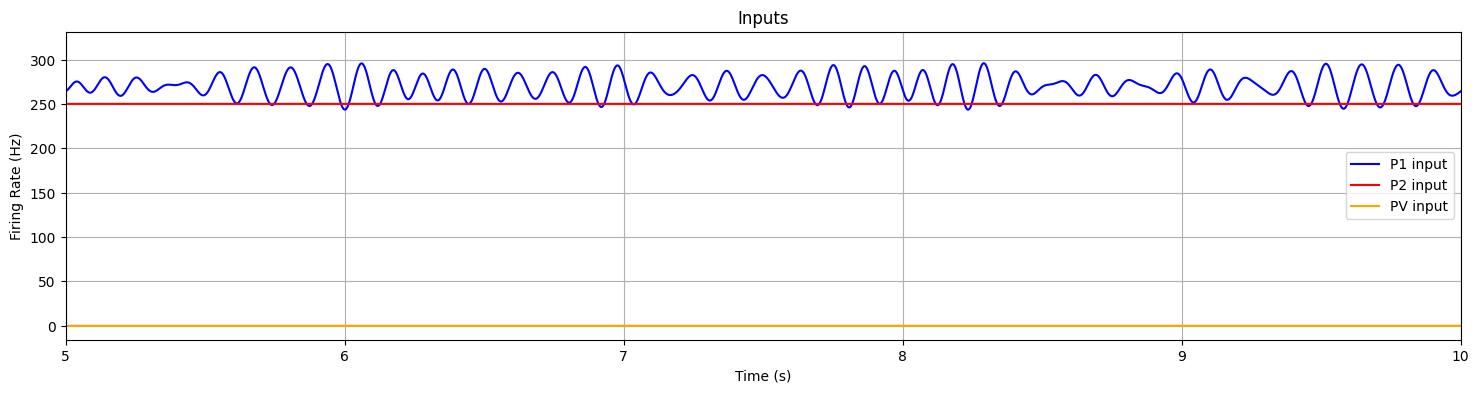

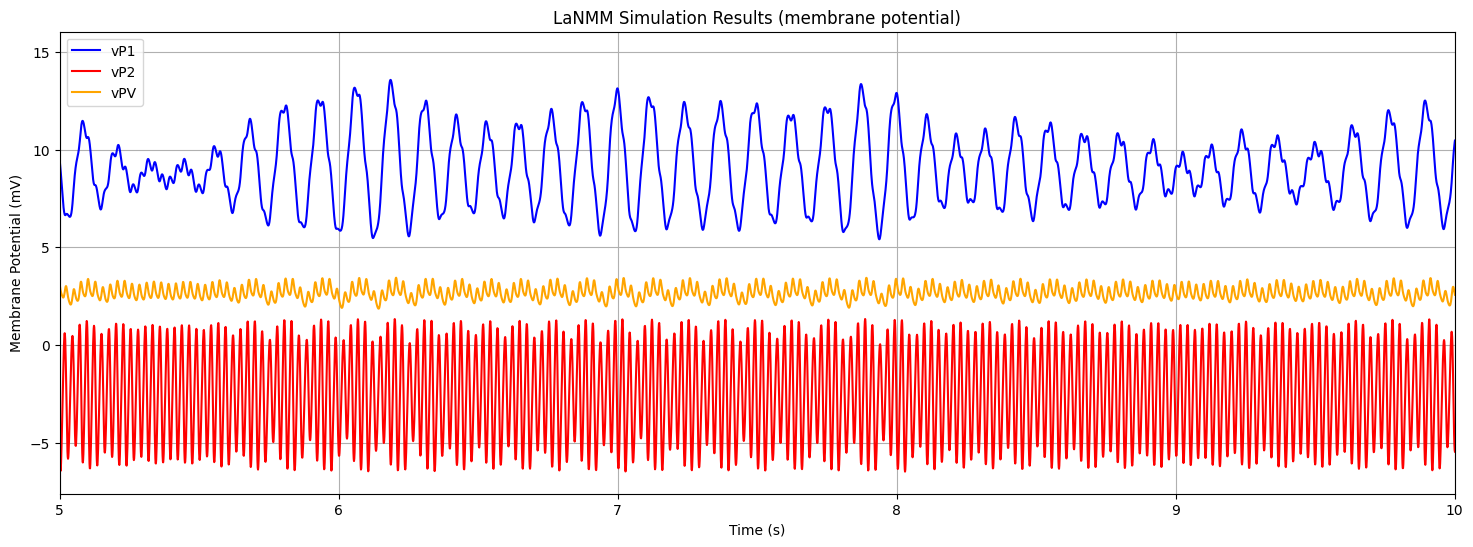

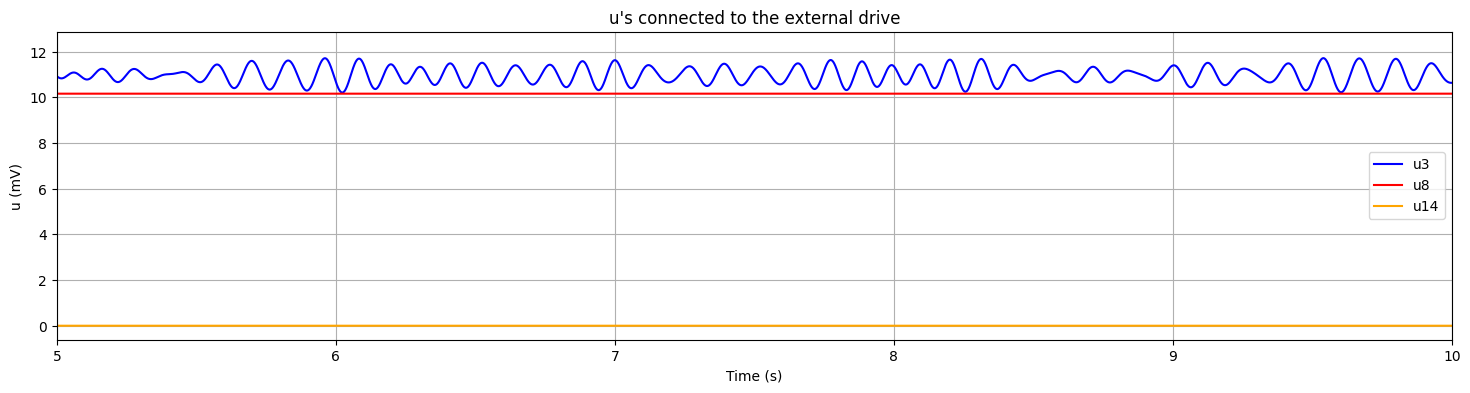

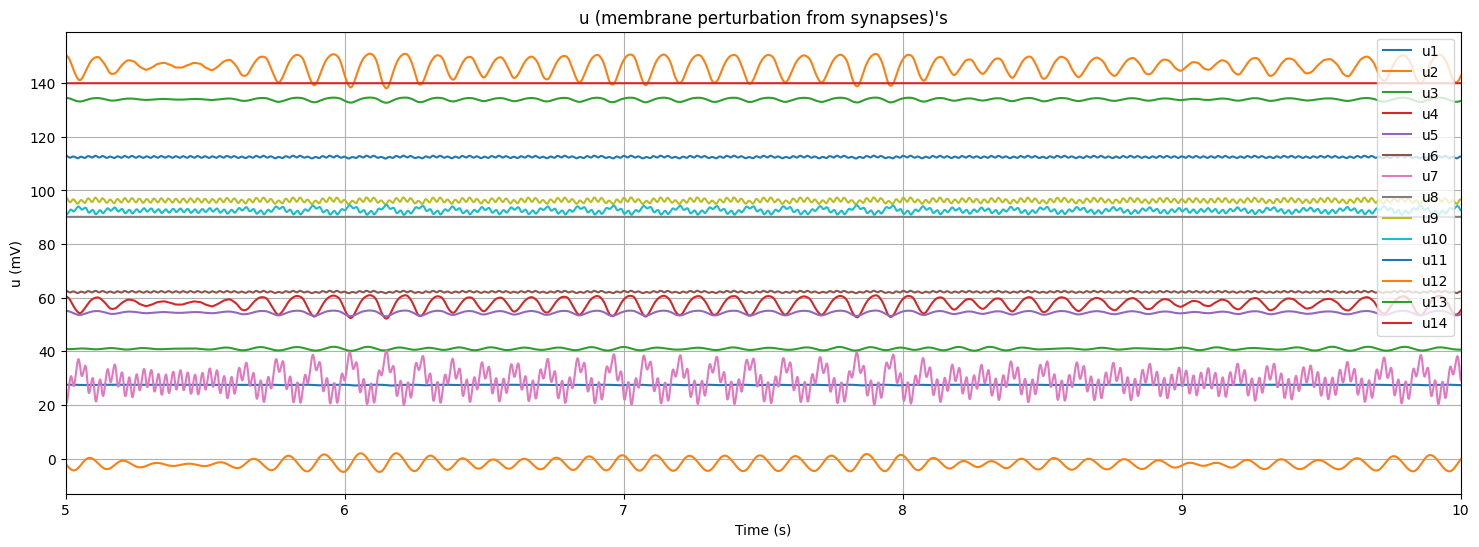

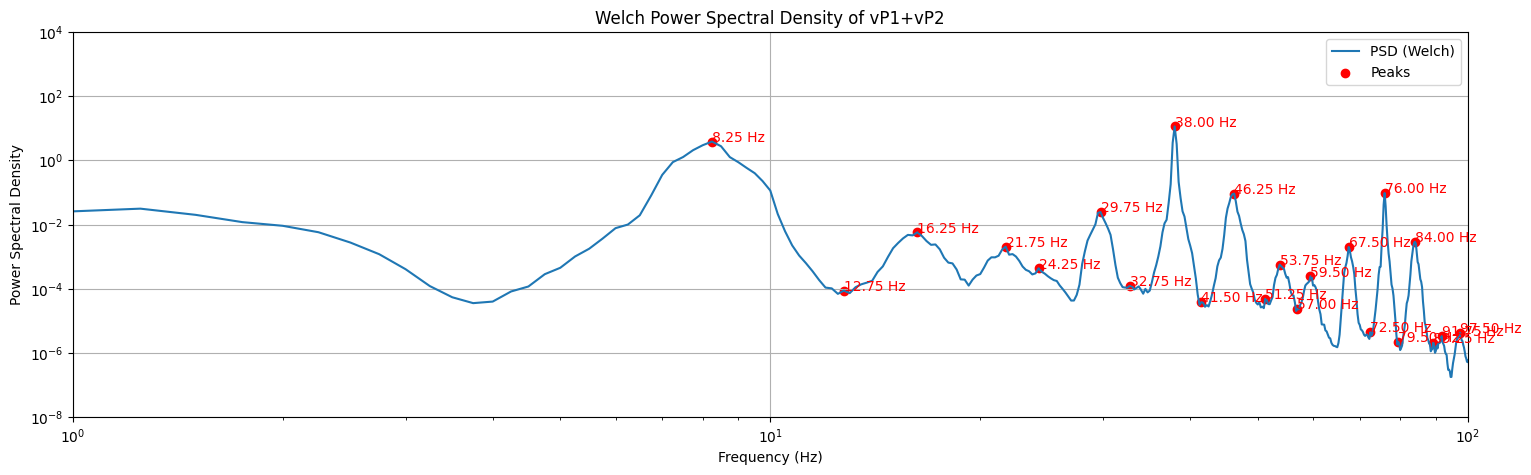

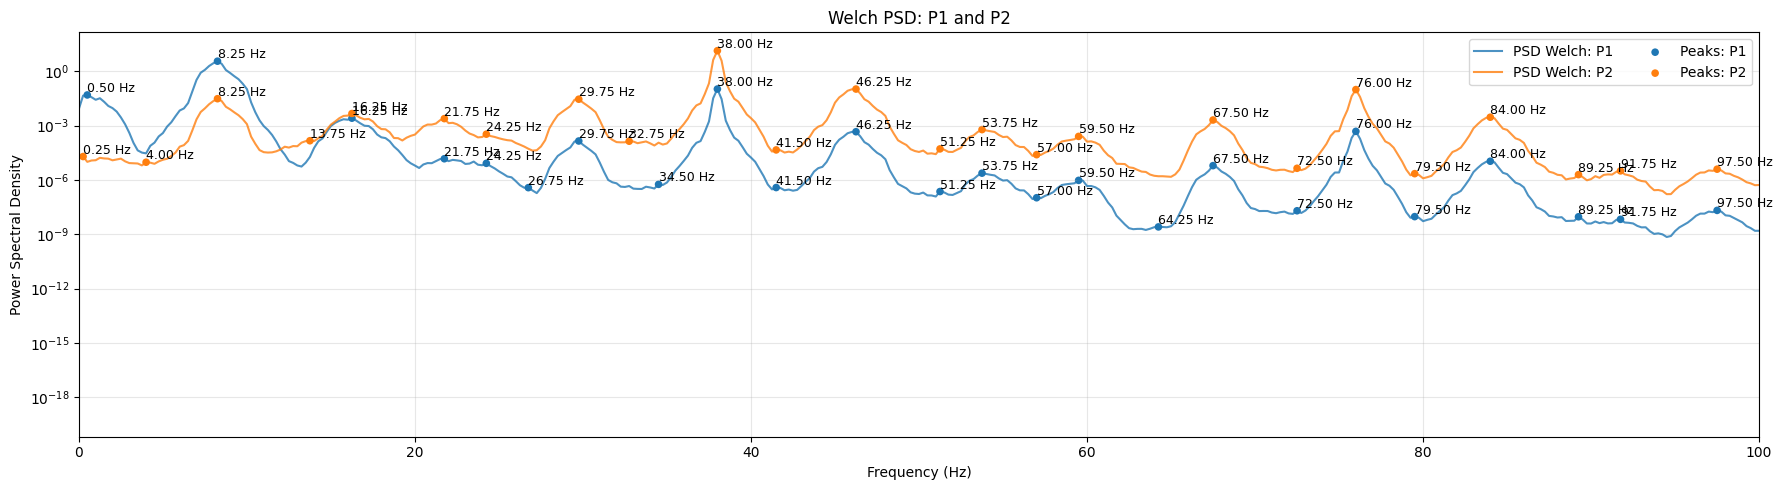

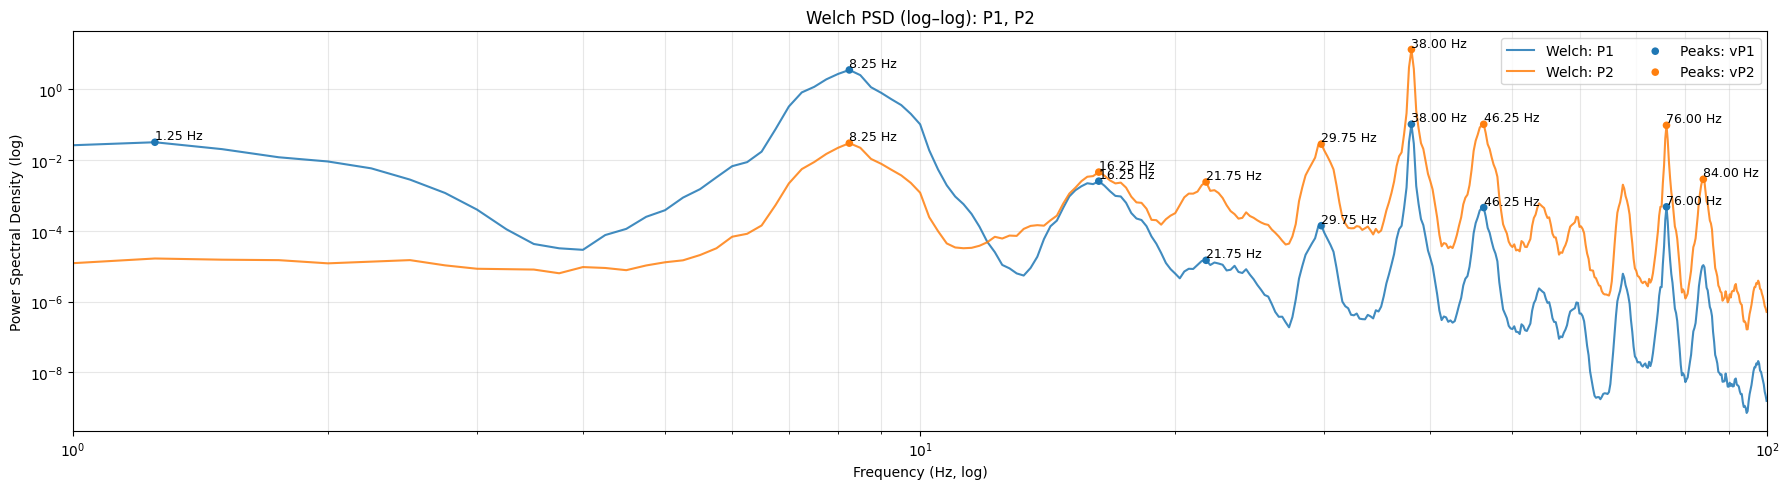

In [6]:

# run the simulation
sim_results = run_unified_simulation(intrinsic_params, driving_params, tmax=tmax, dt=dt, discard=3)

# create a directory to save the results with a timestamped name
# then save the driving params and intrinsic params to a file and 
# then plot the figures and save them too to the folder
import os
from datetime import datetime
import json

# Create timestamped directory name
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = f'results_{timestamp}'

# Create directory
os.makedirs(results_dir, exist_ok=True)

# Save parameters to JSON files
params_to_save = {
    'intrinsic_params': intrinsic_params,
    'driving_params': driving_params
    
}

for param_name, param_dict in params_to_save.items():
    param_file = os.path.join(results_dir, f'{param_name}.json')
    with open(param_file, 'w') as f:
        json.dump(param_dict, f, indent=4)

# Plot and save figures
plot_sim_results(sim_results, save_path=os.path.join(results_dir, ''), show=True)

In [7]:
 
# compute analytic signal
analytic_sig = hilbert(detrend(sim_results["vP2"]))
# envelope is magnitude of the analytic signal
Env_vP2= np.abs(analytic_sig)


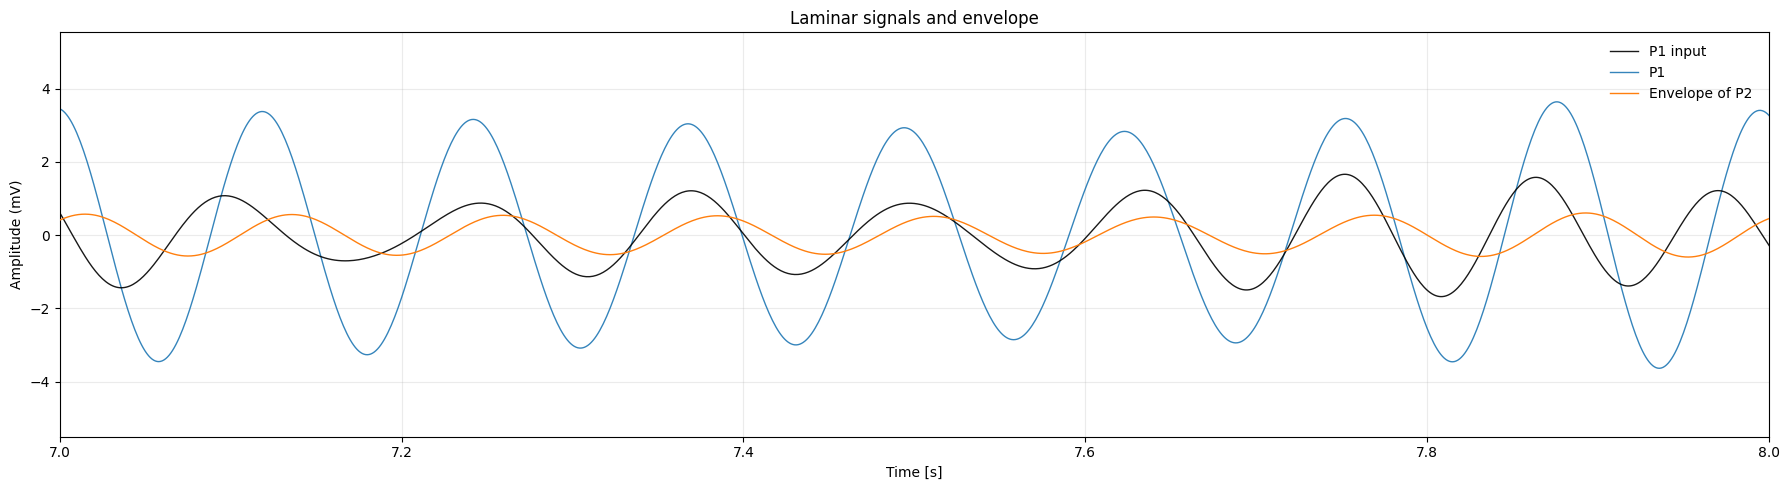

In [8]:
s1 =detrend(sim_results["e1_array"])*0.07
s2 = detrend(sim_results["vP1"])
s2= bandpass_filter(s2, fs=1000, lowcut=driving_params['e1']['am_params']['envelope_band'][0], 
                     highcut=driving_params['e1']['am_params']['envelope_band'][1], order=4)
s3 = detrend(Env_vP2)
s3 = bandpass_filter(s3, fs=1000, lowcut=driving_params['e1']['am_params']['envelope_band'][0], 
                     highcut=driving_params['e1']['am_params']['envelope_band'][1], order=4)
t= sim_results["t"]

#plt.plot(sim_results["t"], s1,sim_results["t"],s2,sim_results["t"], s3)
#plt.xlim((6,8))



# --- nice plot ---
plt.figure(figsize=(18, 5))
plt.plot(t, s1, lw=1., alpha=0.9, label="P1 input",  zorder=3, color='k')
plt.plot(t, s2, lw=1., alpha=0.9, label="P1", zorder=2)
plt.plot(t, s3, lw=1., alpha=1.0, label="Envelope of P2 ",        zorder=4)

#plt.plot(t, s1, color="0.55", lw=1.8, label="E1 (detrended)")
#plt.plot(t, s2, color="0.35", lw=1.8, label="vP1 (detrended)")
#plt.plot(t, s3, color="0.00", lw=2.4, label="Env(vP2)")

plt.xlim(7, 8)                    # time window
plt.xlabel("Time [s]")
plt.ylabel("Amplitude (mV)")
plt.title("Laminar signals and envelope")
plt.grid(True, alpha=0.25, linewidth=0.8)
leg = plt.legend(loc="upper right", frameon=False)  # legend placement
plt.tight_layout()                # tidy margins
plt.show()


best lag and r: 45 -0.5257116022563888


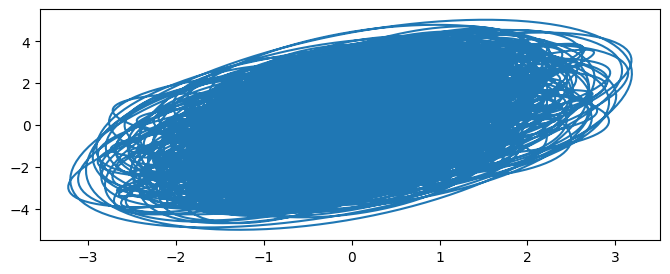

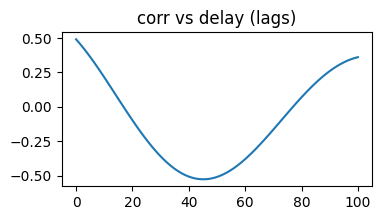

In [9]:

plt.plot(s1,s2)
np.corrcoef(s1,s2)
out=max_corr_directional(s1, s2, max_lag=100, fs=1000, maximize="abs", nan_policy="omit")


best lag and r: 44 -0.9802629855220742


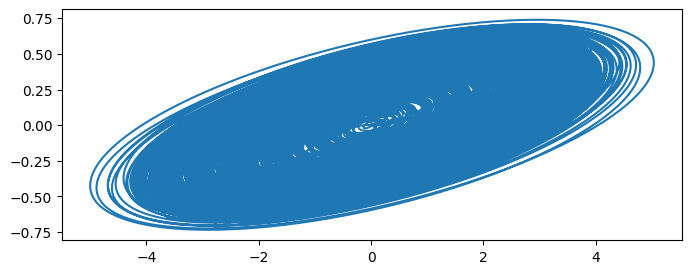

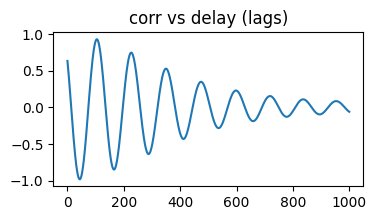

In [10]:

plt.plot(s2,s3)
out=max_corr_directional(s2, s3, max_lag=1000, fs=1000, maximize="abs", nan_policy="omit")

best lag and r: 29 -0.5173503382503472


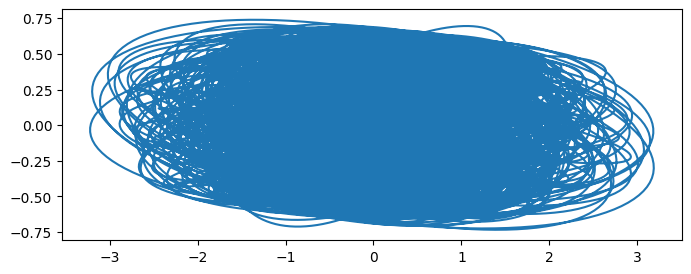

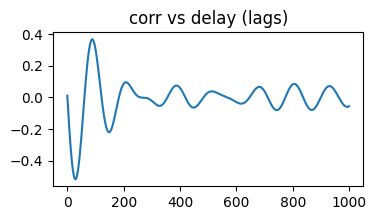

In [11]:
plt.plot(s1,s3)
out=max_corr_directional(s1, s3, max_lag=1000, fs=1000, maximize="abs", nan_policy="omit")

# Second simulation: envelope extraction. Send modulated signal to P2, get envelope out of P1

In [12]:
driving_params = {'e1': {'mode': 'constant',
  'mu': 270.0,
  'am_params': {'carrier_freq': 40.0,
   'envelope_band': (4, 8),
   'slow_band': (0.5, 2),
   'carrier_amplitude': 400.0,
   'mod_index_slow': 0.0,
   'mod_index_fast': 0.5},
  'multiscale_params': {'slow_std': 400.0,
   'slow_alpha': 0.99,
   'fast_std': 5.0,
   'fast_cutoff': 100.0},
  'pulse_params': {'pulse_width': 0.05,
   'pulse_height': 400.0,
   'repetition_rate': 10.0}},
 'e2': {'mode': 'am',
  'mu': 250.0, #90.0,
  'am_params': {'carrier_freq': 40.0,
   'envelope_band': (6, 11),
   'slow_band': (0.3, 1),
   'carrier_amplitude': 50.0,
   'mod_index_slow': 0.,  
   'mod_index_fast': 5},
  'multiscale_params': {'slow_std': 400.0,
   'slow_alpha': 0.99,
   'fast_std': 5.0,
   'fast_cutoff': 100.0},
  'pulse_params': {'pulse_width': 0.025,
   'pulse_height': 400.0,
   'repetition_rate': 40.0}},
 'pv': {'mode': 'constant',
  'mu': 0.0,
  'am_params': {'carrier_freq': 0.0,
   'envelope_band': (8, 12),
   'slow_band': (0.5, 2),
   'carrier_amplitude': 400.0,
   'mod_index_slow': 0.9,
   'mod_index_fast': 0.5},
  'multiscale_params': {'slow_std': 400.0,
   'slow_alpha': 0.99,
   'fast_std': 5.0,
   'fast_cutoff': 100.0},
  'pulse_params': {'pulse_width': 0.01,
   'pulse_height': 400.0,
   'repetition_rate': 20.0}},
 'seed': 42}

In [13]:
intrinsic = get_intrinsic_params()
drives = get_driving_params()
# (… possibly modify drives …)
print(summarize_lanmm_configuration(drives, intrinsic, ndigits=2, markdown=True))

External drives injected at synapses: e1→3, e2→8, pv→14.
Membrane potentials: vP1=u1+u2+u3+u11; vP2=u6+u7+u8+u12; vPV=u9+u10+u13+u14.
Inputs are clipped to ≥ 0 before integration (rectification possible).
- e1: constant (μ = 270), → syn 3. Note: ignored: am_params, multiscale_params, pulse_params.
- e2: constant (μ = 90), → syn 8. Note: ignored: am_params, multiscale_params, pulse_params.
- pv: constant (μ = 0), → syn 14. Note: ignored: am_params, multiscale_params, pulse_params.
- Random seed: 42
- include_PV_drive in intrinsic params = True (not used in posted pipeline).


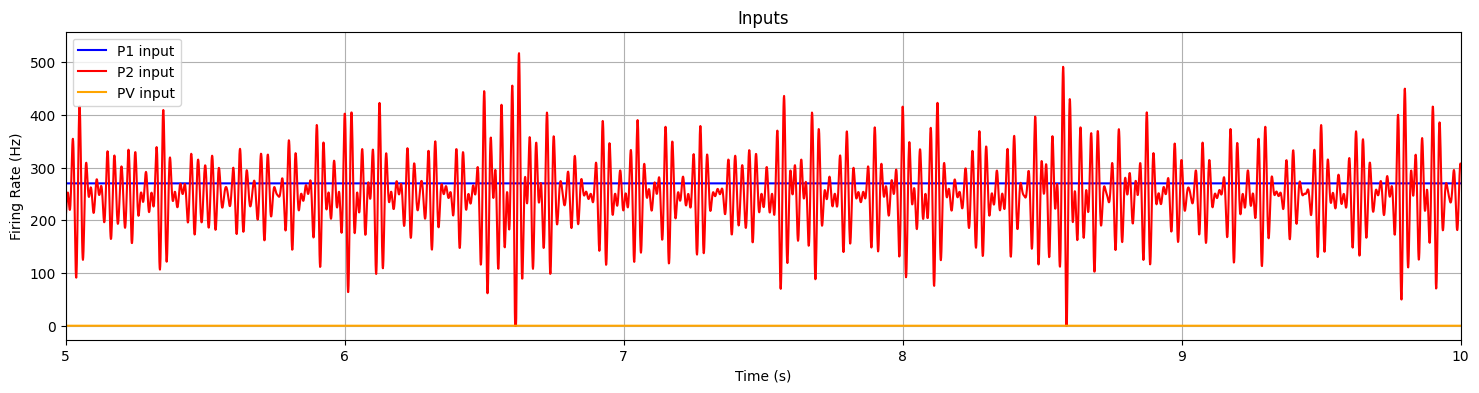

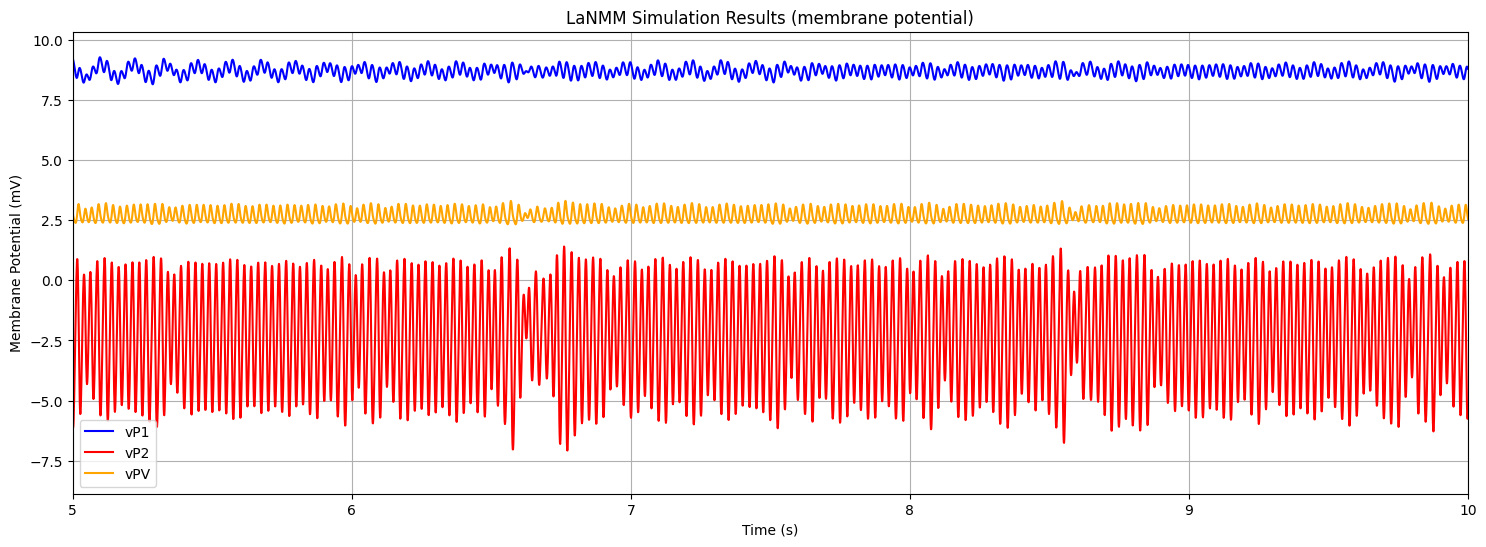

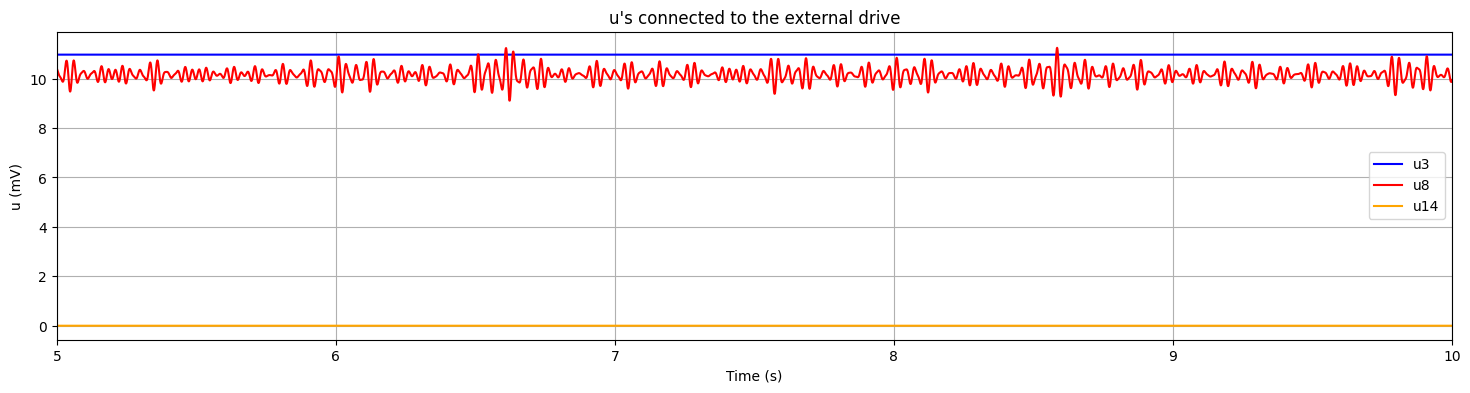

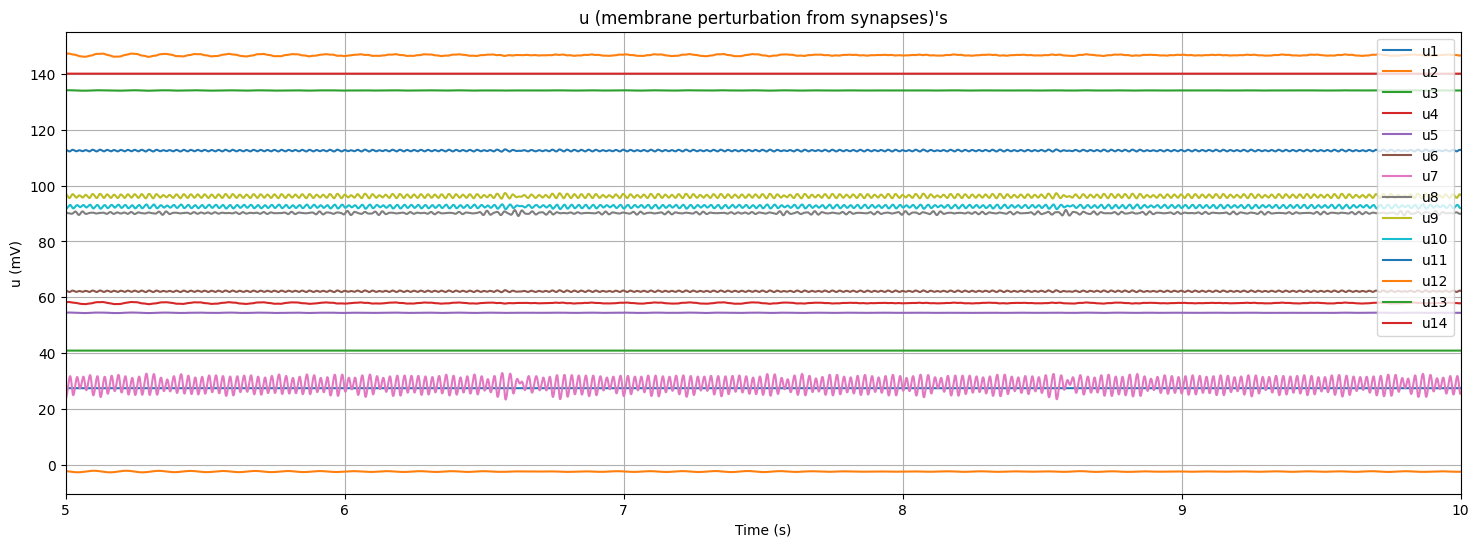

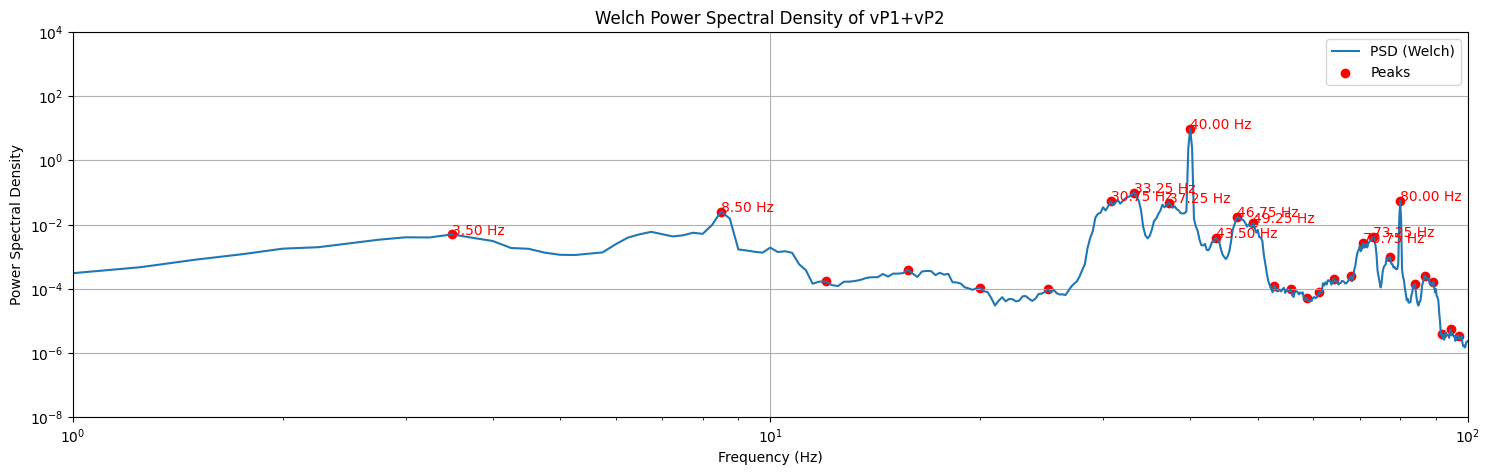

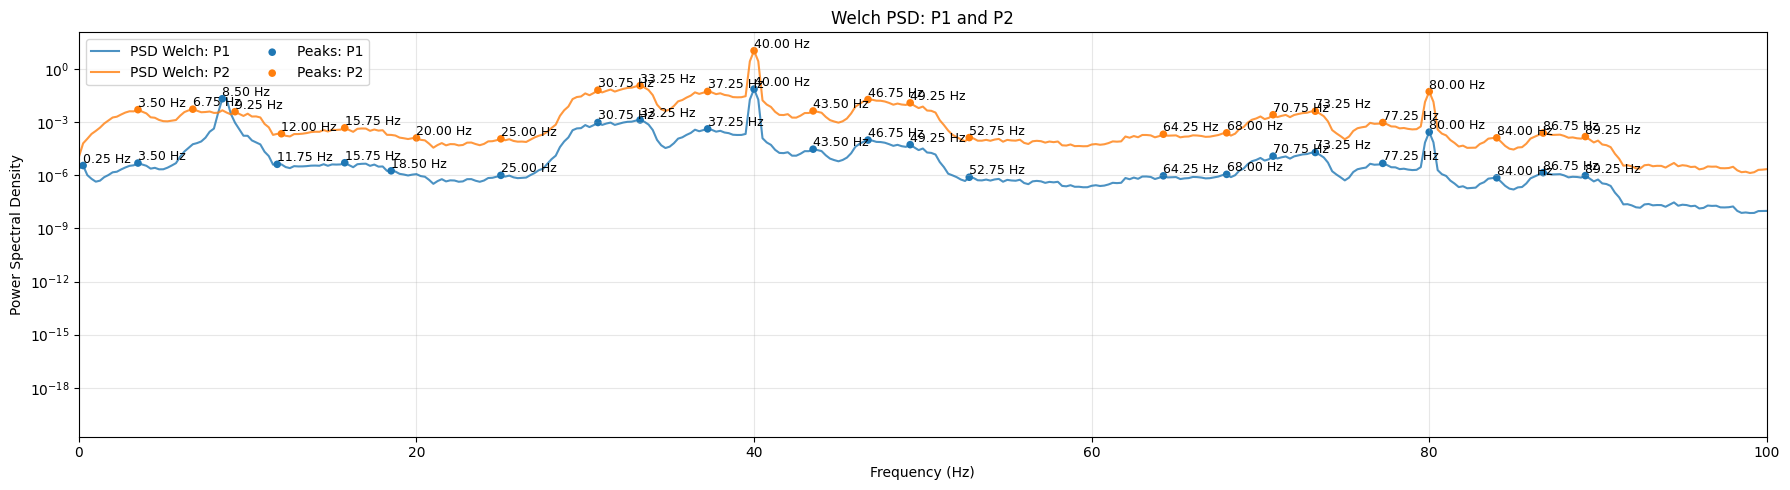

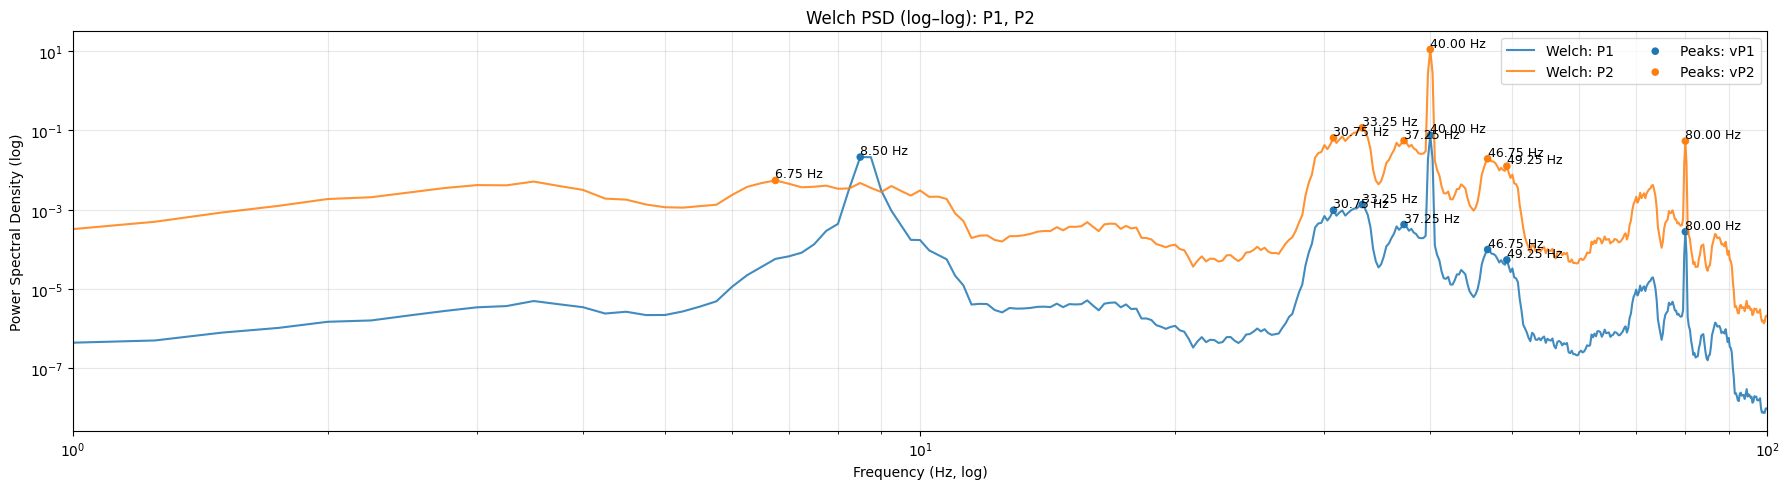

In [14]:

# run the simulation
sim_results = run_unified_simulation(intrinsic_params, driving_params, tmax=tmax, dt=dt, discard=3.0)

# create a directory to save the results with a timestamped name
# then save the driving params and intrinsic params to a file and 
# then plot the figures and save them too to the folder
import os
from datetime import datetime
import json

# Create timestamped directory name
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = f'results_{timestamp}'

# Create directory
os.makedirs(results_dir, exist_ok=True)

# Save parameters to JSON files
params_to_save = {
    'intrinsic_params': intrinsic_params,
    'driving_params': driving_params
}

for param_name, param_dict in params_to_save.items():
    param_file = os.path.join(results_dir, f'{param_name}.json')
    with open(param_file, 'w') as f:
        json.dump(param_dict, f, indent=4)

# Plot and save figures
plot_sim_results(sim_results, save_path=os.path.join(results_dir, ''), show=True)

In [15]:
# compute analytic signal
analytic_sig = hilbert(detrend(sim_results["vP2"]))
# envelope is magnitude of the analytic signal
Env_vP2= np.abs(analytic_sig)


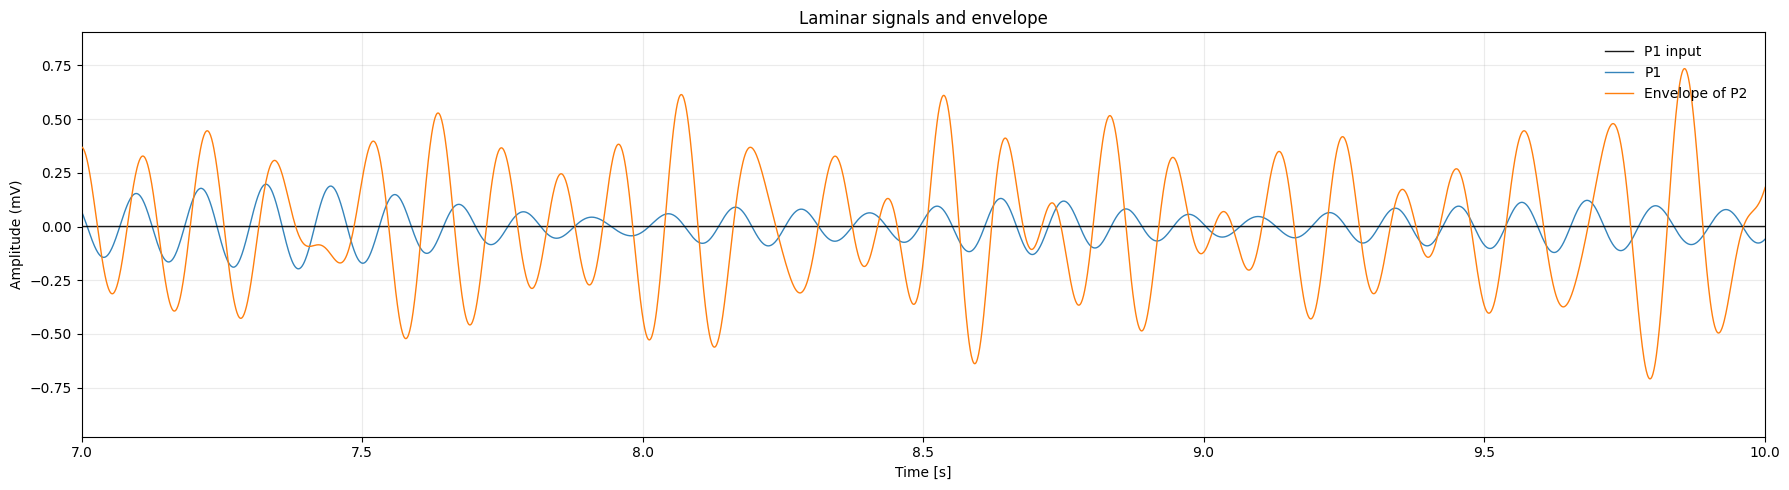

In [16]:
s1 =detrend(sim_results["e1_array"])*0.07
s2 = detrend(sim_results["vP1"])
s2= bandpass_filter(s2, fs=1000, lowcut=driving_params['e2']['am_params']['envelope_band'][0], 
                    highcut=driving_params['e2']['am_params']['envelope_band'][1], order=4)
s3 = detrend(Env_vP2)
s3 = bandpass_filter(s3, fs=1000, lowcut=driving_params['e2']['am_params']['envelope_band'][0], 
                    highcut=driving_params['e2']['am_params']['envelope_band'][1], order=4)
t= sim_results["t"]

#plt.plot(sim_results["t"], s1,sim_results["t"],s2,sim_results["t"], s3)
#plt.xlim((6,8))



# --- nice plot ---
plt.figure(figsize=(18, 5))
plt.plot(t, s1, lw=1., alpha=0.9, label="P1 input",  zorder=3, color='k')
plt.plot(t, s2, lw=1., alpha=0.9, label="P1", zorder=2)
plt.plot(t, s3, lw=1., alpha=1.0, label="Envelope of P2 ",        zorder=4)

#plt.plot(t, s1, color="0.55", lw=1.8, label="E1 (detrended)")
#plt.plot(t, s2, color="0.35", lw=1.8, label="vP1 (detrended)")
#plt.plot(t, s3, color="0.00", lw=2.4, label="Env(vP2)")

plt.xlim(7,10 )                    # time window
plt.xlabel("Time [s]")
plt.ylabel("Amplitude (mV)")
plt.title("Laminar signals and envelope")
plt.grid(True, alpha=0.25, linewidth=0.8)
leg = plt.legend(loc="upper right", frameon=False)  # legend placement
plt.tight_layout()                # tidy margins
plt.show()


best lag and r: 162 -0.44627711644857265


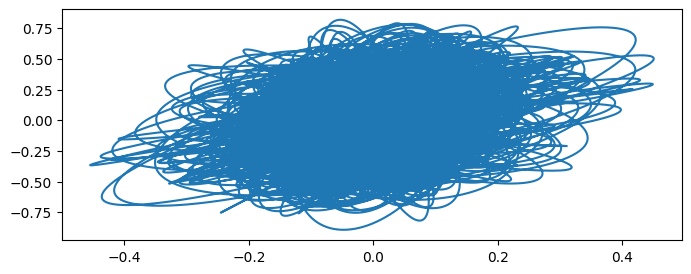

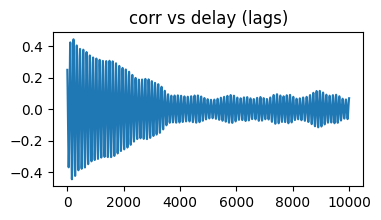

In [17]:

plt.plot(s2,s3)
out=max_corr_directional(s2, s3, max_lag=10000, fs=1000, maximize="abs", nan_policy="omit")